c:\Users\LENOVO\Documents\Paper\Penelitian-Skripsi-Cuaca\venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.0) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
c:\Users\LENOVO\Documents\Paper\Penelitian-Skripsi-Cuaca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



   SISTEM PERINGATAN DINI CUACA EKSTREM (FULL REPORT)
Waktu Run: 2026-02-13 23:47:18

   [BAB 3] PREPROCESSING DATA

>> 1. PEMBERSIHAN DATA (ROBUST)
------------------------------------------------------------
  - Membuang 351 baris karena Target (RR) kosong/NaN.

[Visualisasi 1: Dinamika Curah Hujan]


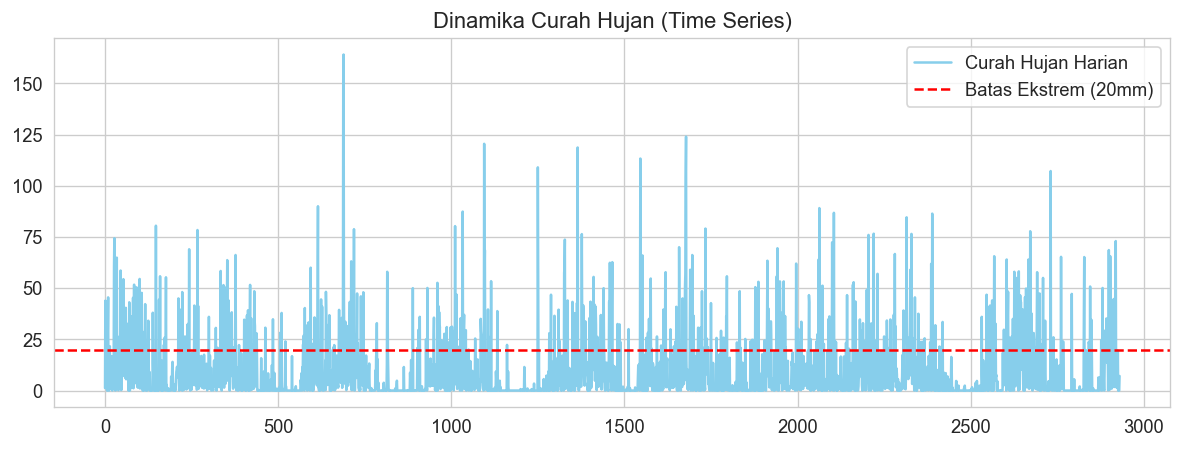


>> 2. REKAYASA FITUR (PREVIEW)
------------------------------------------------------------
CONTOH DATASET SETELAH FEATURE ENGINEERING:
            TAVG  RH_AVG   SS  FF_AVG  RR_Lag1  RR_Lag2  RR_Lag3  TAVG_Lag1  TAVG_Lag2  TAVG_Lag3  RH_AVG_Lag1  RH_AVG_Lag2  RH_AVG_Lag3  SS_Lag1  SS_Lag2  SS_Lag3  FF_AVG_Lag1  FF_AVG_Lag2  FF_AVG_Lag3  RR_Roll3_Mean  RR_Roll3_Max
2016-01-04  22.0    90.0  1.6     0.0     43.9      1.2      1.2       21.6       21.5       21.5         89.0         90.0         90.0      1.4      0.1      0.1          0.0          0.0          0.0      15.433333          43.9
2016-01-05  22.0    90.0  1.6     0.0      8.7     43.9      1.2       22.0       21.6       21.5         90.0         89.0         90.0      1.6      1.4      0.1          0.0          0.0          0.0      17.933333          43.9
2016-01-06  22.3    84.0  1.8     0.0      8.7      8.7     43.9       22.0       22.0       21.6         90.0         90.0         89.0      1.6      1.6      1.4    

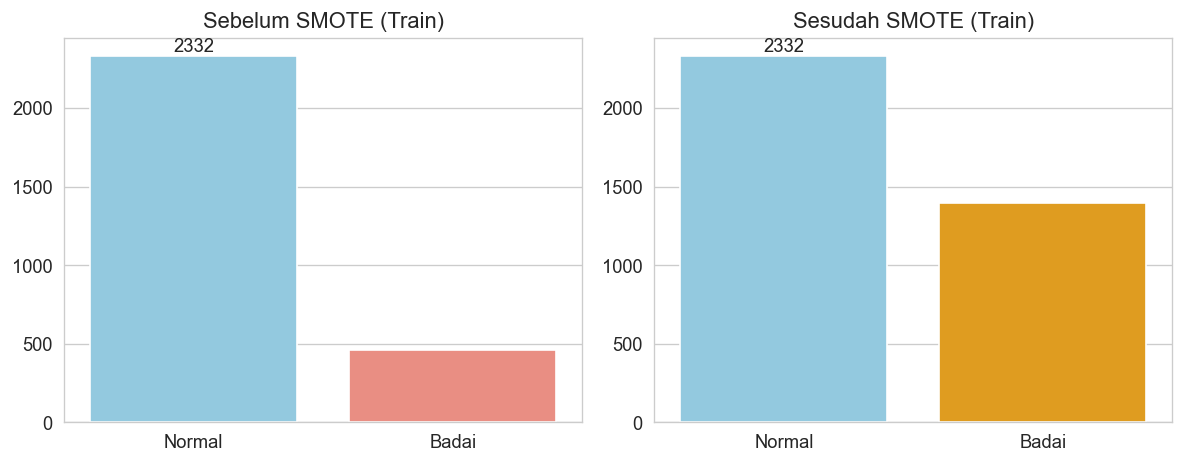


   [BAB 4] TRAINING MODEL

>> 1. XGBOOST (OPTUNA TUNING)
------------------------------------------------------------
  Menjalankan Optuna (15 Trials)...
  [OK] XGBoost Selesai. Params: {'n_estimators': 309, 'learning_rate': 0.026636900997297437, 'max_depth': 6, 'subsample': 0.8325398470083344, 'colsample_bytree': 0.8818496824692568, 'scale_pos_weight': 3.3422410256414734}

>> 2. LSTM (GRID SEARCH MANUAL)
------------------------------------------------------------
  Testing Grid: {'class_weight_ratio': 2.0, 'units': 32} ... Val Acc: 0.8479
  Testing Grid: {'class_weight_ratio': 2.0, 'units': 64} ... Val Acc: 0.8462
  Testing Grid: {'class_weight_ratio': 3.0, 'units': 32} ... Val Acc: 0.8462
  Testing Grid: {'class_weight_ratio': 3.0, 'units': 64} ... Val Acc: 0.8569
  Winner LSTM: {'class_weight_ratio': 3.0, 'units': 64}

[Visualisasi 5: Training History LSTM]


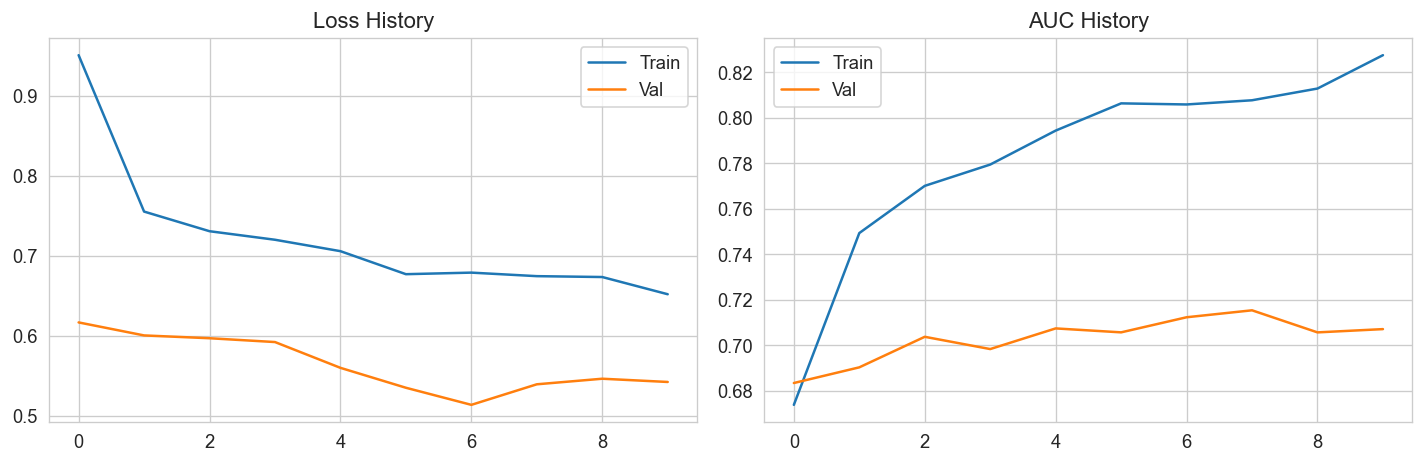


   [BAB 5] HASIL AKHIR & DISKUSI
MANUAL THRESHOLD APPLIED:
 -> XGBoost Threshold : 0.35
 -> LSTM Threshold    : 0.45

>>> LAPORAN FINAL: XGBoost (Optuna)
    Threshold          : 0.35
    Accuracy           : 81.54%
    Recall (Bahaya)    : 48.89%
    Precision          : 49.44%
    F1 Score           : 0.4916
    AUC Score          : 0.8115

    [CLASSIFICATION REPORT]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       403
           1       0.49      0.49      0.49        90

    accuracy                           0.82       493
   macro avg       0.69      0.69      0.69       493
weighted avg       0.81      0.82      0.82       493


>>> LAPORAN FINAL: LSTM (Grid Search)
    Threshold          : 0.45
    Accuracy           : 78.50%
    Recall (Bahaya)    : 45.56%
    Precision          : 41.84%
    F1 Score           : 0.4362
    AUC Score          : 0.8096

    [CLASSIFICATION REPORT]
              precision    recall  f1-sco

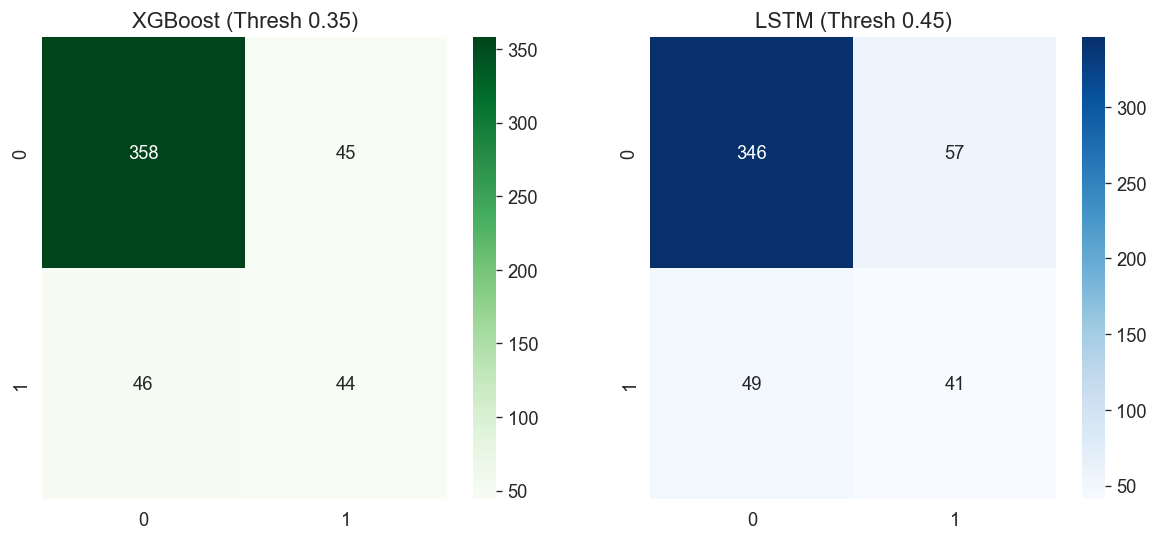


[Visualisasi 7: ROC Curve]


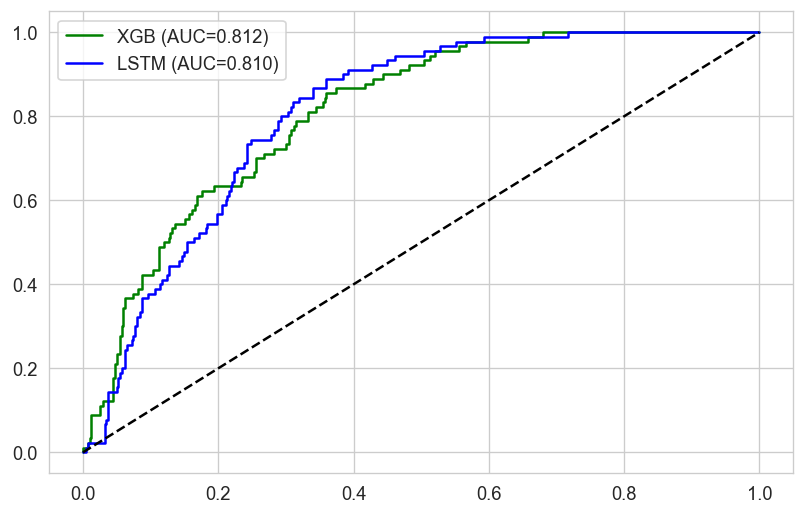


[Visualisasi 8: Prediksi Real-Time XGBoost


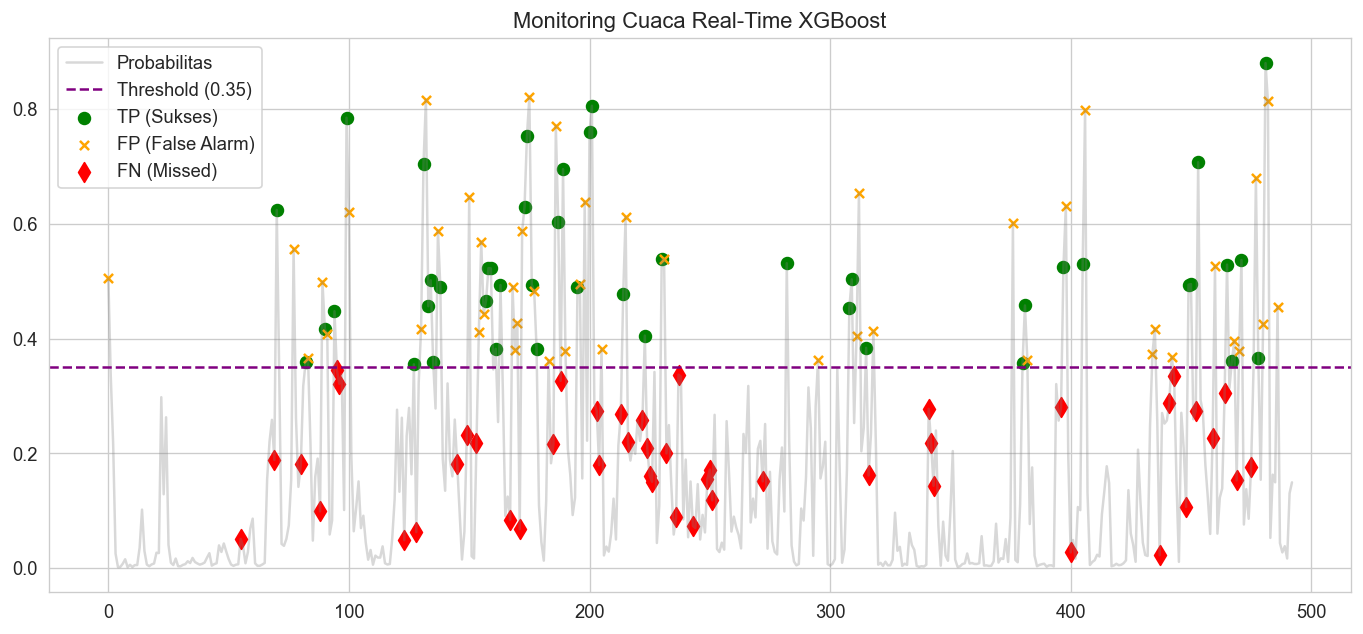


[Visualisasi 9: Fitur Terpenting (XGBoost)]


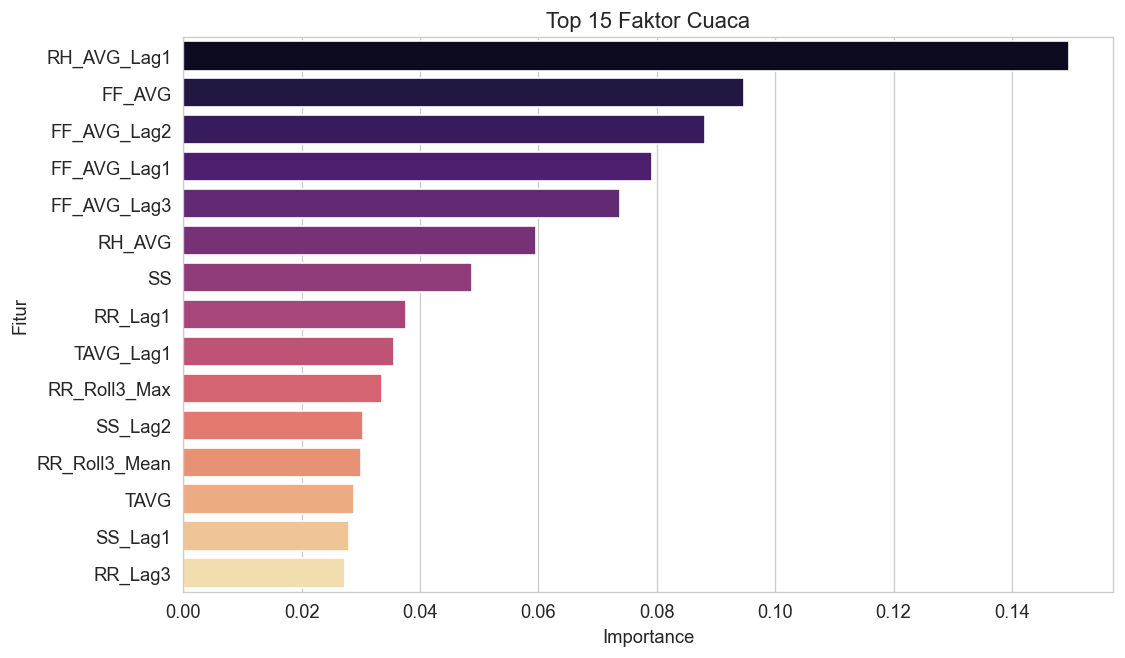


[SELESAI] Semua hasil telah dikunci dan visualisasi lengkap.


In [1]:
# ==========================================================================================
# SKRIPSI FINAL: SISTEM DETEKSI CUACA EKSTREM (XGBOOST OPTUNA & LSTM GRID SEARCH)
# AUTHOR: [NAMA ANDA]
# FITUR: 
#  1. AUDIT DATA & VISUALISASI LENGKAP
#  2. DETAIL SPLITTING (TRAIN/TEST COUNT)
#  3. TUNING (OPTUNA & GRID)
#  4. THRESHOLD LOCKED (XGB=0.35, LSTM=0.45)
# ==========================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
import warnings
import sys
import os
import time
import optuna
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, 
                             precision_score, f1_score, roc_auc_score, 
                             roc_curve, classification_report)
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import ParameterGrid

# --- [1] KONFIGURASI SISTEM & KUNCI SEED (WAJIB) ---
try:
    if not hasattr(sys.stdout, 'encoding'): sys.stdout.encoding = 'utf-8'
except: pass

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING) 
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11, 'figure.dpi': 120})

FILE_PATH = 'DataBMKG20242016.csv'
TARGET_THRESHOLD = 20.0
TEST_SIZE = 0.15
RANDOM_STATE = 42

# KUNCI MATI SEMUA RANDOMNESS
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

def print_header(title):
    print(f"\n{'='*80}")
    print(f"   {title}")
    print(f"{'='*80}")

def print_section(title):
    print(f"\n>> {title}")
    print("-" * 60)

print_header("SISTEM PERINGATAN DINI CUACA EKSTREM (FULL REPORT)")
print(f"Waktu Run: {time.strftime('%Y-%m-%d %H:%M:%S')}")

# ==========================================================================================
# [BAB 3] PREPROCESSING & EDA
# ==========================================================================================
print_header("[BAB 3] PREPROCESSING DATA")

if not os.path.exists(FILE_PATH): sys.exit("ERROR: File CSV tidak ditemukan!")
df = pd.read_csv(FILE_PATH)
df.rename(columns={'TAVG': 'TAVG', 'RH_AVG': 'RH_AVG', 'FF_AVG': 'FF_AVG', 'SS': 'SS'}, inplace=True)

# 1. CLEANING ROBUST
print_section("1. PEMBERSIHAN DATA (ROBUST)")
cols_check = ['RR', 'TAVG', 'RH_AVG', 'SS', 'FF_AVG']

def clean_bmkg_robust(val):
    s = str(val).strip()
    if s in ['8888', '9999', '-', '', 'nan', 'None']: return np.nan
    try:
        f = float(s)
        return np.nan if f in [8888, 9999] else f
    except: return np.nan

for col in cols_check:
    if col in df.columns: df[col] = df[col].apply(clean_bmkg_robust)

if 'TANGGAL' in df.columns:
    df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format='%d-%m-%Y', errors='coerce')
    df = df.sort_values('TANGGAL')
    df = df.drop_duplicates(subset=['TANGGAL'], keep='first')

missing_target = df['RR'].isnull().sum()
print(f"  - Membuang {missing_target} baris karena Target (RR) kosong/NaN.")
df = df.dropna(subset=['RR']).interpolate(method='linear', limit_direction='both')
df['Target'] = (df['RR'] > TARGET_THRESHOLD).astype(int)

# VISUALISASI 1: TREN DATA
print("\n[Visualisasi 1: Dinamika Curah Hujan]")
plt.figure(figsize=(12, 4))
plt.plot(df['RR'].values, color='skyblue', label='Curah Hujan Harian')
plt.axhline(TARGET_THRESHOLD, color='red', linestyle='--', label='Batas Ekstrem (20mm)')
plt.title('Dinamika Curah Hujan (Time Series)')
plt.legend()
plt.show()

# 2. FEATURE ENGINEERING
print_section("2. REKAYASA FITUR (PREVIEW)")
if 'TANGGAL' in df.columns:
    df = df.set_index('TANGGAL').reindex(pd.date_range(df['TANGGAL'].min(), df['TANGGAL'].max()), method='ffill')

# Lags
for col in cols_check:
    if col in df.columns:
        for i in [1, 2, 3]: df[f'{col}_Lag{i}'] = df[col].shift(i)

df['RR_Roll3_Mean'] = df['RR_Lag1'].rolling(3).mean()
df['RR_Roll3_Max'] = df['RR_Lag1'].rolling(3).max()

df_model = df.dropna()
X = df_model.drop(['RR', 'Target'], axis=1, errors='ignore').select_dtypes(include=[np.number])
y = df_model['Target']
feature_names = X.columns.tolist()

print("CONTOH DATASET SETELAH FEATURE ENGINEERING:")
print(X.head(5).to_string())
print("-" * 60)
print(f"  - Total Fitur  : {len(feature_names)}")
print(f"  - Total Sampel : {len(df_model)}")

# 3. SPLIT & SMOTE
print_section("3. DETAIL SPLITTING & SMOTE")
train_size = int(len(df_model) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Hitung Detail
n_train_0 = (y_train == 0).sum()
n_train_1 = (y_train == 1).sum()
n_test_0 = (y_test == 0).sum()
n_test_1 = (y_test == 1).sum()

print(f"[DATA SPLITTING REPORT]")
print(f"  1. TOTAL DATA   : {len(df_model)} Baris")
print(f"  2. TRAINING SET : {len(X_train)} Baris ({100-TEST_SIZE*100:.0f}%)")
print(f"     - Normal (0) : {n_train_0}")
print(f"     - Badai  (1) : {n_train_1}")
print(f"     - Rasio Asli : 1 : {n_train_0/n_train_1:.2f}")
print(f"  3. TESTING SET  : {len(X_test)} Baris ({TEST_SIZE*100:.0f}%)")
print(f"     - Normal (0) : {n_test_0}")
print(f"     - Badai  (1) : {n_test_1}")

# Apply SMOTE
smote = SMOTE(sampling_strategy=0.6, random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

n_smote_0 = (y_train_smote == 0).sum()
n_smote_1 = (y_train_smote == 1).sum()

print(f"  4. AFTER SMOTE (TRAIN ONLY)")
print(f"     - Normal (0) : {n_smote_0}")
print(f"     - Badai  (1) : {n_smote_1}")
print(f"     - Rasio Baru : 1 : {n_smote_0/n_smote_1:.2f}")

# VISUALISASI 2: SMOTE
print("\n[Visualisasi 2: Dampak Penyeimbangan Data (SMOTE)]")
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(x=['Normal', 'Badai'], y=[n_train_0, n_train_1], palette=['skyblue', 'salmon'], ax=ax[0])
ax[0].set_title(f'Sebelum SMOTE (Train)')
ax[0].bar_label(ax[0].containers[0])
sns.barplot(x=['Normal', 'Badai'], y=[n_smote_0, n_smote_1], palette=['skyblue', 'orange'], ax=ax[1])
ax[1].set_title(f'Sesudah SMOTE (Train)')
ax[1].bar_label(ax[1].containers[0])
plt.tight_layout()
plt.show()

# ==========================================================================================
# [BAB 4] TRAINING MODEL
# ==========================================================================================
print_header("[BAB 4] TRAINING MODEL")

# --- 1. XGBOOST (OPTUNA) ---
print_section("1. XGBOOST (OPTUNA TUNING)")

def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 400),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2.0, 3.5),
        'random_state': RANDOM_STATE, 'n_jobs': -1, 'eval_metric': 'logloss'
    }
    model = xgb.XGBClassifier(**param)
    idx = int(len(X_train_smote) * 0.85)
    model.fit(X_train_smote.iloc[:idx], y_train_smote.iloc[:idx])
    preds = model.predict(X_train_smote.iloc[idx:])
    
    acc = accuracy_score(y_train_smote.iloc[idx:], preds)
    f1 = f1_score(y_train_smote.iloc[idx:], preds)
    
    if acc < 0.79: return acc - 1 
    return f1

sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE) 
study_xgb = optuna.create_study(direction='maximize', sampler=sampler)
print("  Menjalankan Optuna (15 Trials)...")
study_xgb.optimize(objective_xgb, n_trials=15)

best_xgb = xgb.XGBClassifier(**study_xgb.best_params, random_state=RANDOM_STATE, n_jobs=-1)
best_xgb.fit(X_train_smote, y_train_smote)
print(f"  [OK] XGBoost Selesai. Params: {study_xgb.best_params}")

# --- 2. LSTM (GRID SEARCH) ---
print_section("2. LSTM (GRID SEARCH MANUAL)")
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_train_lstm = X_train_sc.reshape((X_train_sc.shape[0], 1, X_train_sc.shape[1]))
X_test_lstm = X_test_sc.reshape((X_test_sc.shape[0], 1, X_test_sc.shape[1]))

param_grid = {
    'units': [32, 64],
    'class_weight_ratio': [2.0, 3.0] 
}
grid = list(ParameterGrid(param_grid))
best_score = -1
best_params = None
best_lstm_model = None
history_best = None

for params in grid:
    print(f"  Testing Grid: {params} ... ", end="")
    model = Sequential([
        Input(shape=(1, X_train_sc.shape[1])),
        Bidirectional(LSTM(params['units'], return_sequences=True)), 
        BatchNormalization(), Dropout(0.3),
        Bidirectional(LSTM(int(params['units']/2), return_sequences=False)), 
        BatchNormalization(), Dropout(0.3),
        Dense(16, activation='relu'), Dense(1, activation='sigmoid')
    ])
    
    # FIX ERROR DISINI: Tambahkan metric AUC eksplisit dengan nama 'auc'
    model.compile(optimizer=Adam(0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
    h = model.fit(X_train_lstm, y_train, epochs=20, batch_size=32,
                  validation_split=0.2, 
                  class_weight={0: 1.0, 1: params['class_weight_ratio']},
                  callbacks=[es], verbose=0)
    
    val_acc = max(h.history['val_accuracy'])
    print(f"Val Acc: {val_acc:.4f}")
    if val_acc > best_score:
        best_score = val_acc
        best_params = params
        best_lstm_model = model
        history_best = h

print(f"  Winner LSTM: {best_params}")
final_lstm = best_lstm_model 

# VISUALISASI 5: TRAINING HISTORY (DARI MODEL TERBAIK)
print("\n[Visualisasi 5: Training History LSTM]")
if history_best:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_best.history['loss'], label='Train')
    plt.plot(history_best.history['val_loss'], label='Val')
    plt.title('Loss History')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    # Gunakan key 'auc' dan 'val_auc' yang sudah dipastikan ada
    if 'auc' in history_best.history:
        plt.plot(history_best.history['auc'], label='Train')
        plt.plot(history_best.history['val_auc'], label='Val')
        plt.title('AUC History')
        plt.legend()
    plt.tight_layout()
    plt.show()

# ==========================================================================================
# [BAB 5] HASIL & EVALUASI (HARDCODED THRESHOLD)
# ==========================================================================================
print_header("[BAB 5] HASIL AKHIR & DISKUSI")

prob_xgb = best_xgb.predict_proba(X_test)[:, 1]
prob_lstm = final_lstm.predict(X_test_lstm, verbose=0).flatten()

# --- PENETAPAN THRESHOLD MANUAL ---
t_xgb = 0.35
t_lstm = 0.45

print(f"MANUAL THRESHOLD APPLIED:")
print(f" -> XGBoost Threshold : {t_xgb}")
print(f" -> LSTM Threshold    : {t_lstm}")

# Generate Prediksi
pred_xgb = (prob_xgb >= t_xgb).astype(int)
pred_lstm = (prob_lstm >= t_lstm).astype(int)

def detailed_metrics(name, y_true, y_pred, y_prob, t):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, pos_label=1)
    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    auc = roc_auc_score(y_true, y_prob)
    
    print(f"\n>>> LAPORAN FINAL: {name}")
    print(f"    Threshold          : {t:.2f}")
    print(f"    Accuracy           : {acc:.2%}")
    print(f"    Recall (Bahaya)    : {rec:.2%}")
    print(f"    Precision          : {prec:.2%}")
    print(f"    F1 Score           : {f1:.4f}")
    print(f"    AUC Score          : {auc:.4f}")
    
    print("\n    [CLASSIFICATION REPORT]")
    print(classification_report(y_true, y_pred))

detailed_metrics("XGBoost (Optuna)", y_test, pred_xgb, prob_xgb, t_xgb)
detailed_metrics("LSTM (Grid Search)", y_test, pred_lstm, prob_lstm, t_lstm)

# VISUALISASI 6: CONFUSION MATRIX
print("\n[Visualisasi 6: Confusion Matrix]")
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, pred_xgb), annot=True, fmt='d', cmap='Greens', ax=ax[0])
ax[0].set_title(f'XGBoost (Thresh {t_xgb})')
sns.heatmap(confusion_matrix(y_test, pred_lstm), annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title(f'LSTM (Thresh {t_lstm})')
plt.show()

# VISUALISASI 7: ROC CURVE
print("\n[Visualisasi 7: ROC Curve]")
plt.figure(figsize=(8, 5))
fx, tx, _ = roc_curve(y_test, prob_xgb); fl, tl, _ = roc_curve(y_test, prob_lstm)
plt.plot(fx, tx, label=f'XGB (AUC={roc_auc_score(y_test, prob_xgb):.3f})', color='green')
plt.plot(fl, tl, label=f'LSTM (AUC={roc_auc_score(y_test, prob_lstm):.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--'); plt.legend(); plt.show()

# VISUALISASI 8: REAL TIME (DENGAN TANDA TP/FP/FN)
print("\n[Visualisasi 8: Prediksi Real-Time XGBoost")
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_test)), prob_xgb, color='gray', alpha=0.3, label='Probabilitas')
plt.axhline(t_xgb, color='purple', ls='--', label=f'Threshold ({t_xgb})')
tp = (y_test==1) & (pred_xgb==1); fp = (y_test==0) & (pred_xgb==1); fn = (y_test==1) & (pred_xgb==0)
plt.scatter(np.where(tp)[0], prob_xgb[tp], color='green', s=50, label='TP (Sukses)')
plt.scatter(np.where(fp)[0], prob_xgb[fp], color='orange', s=30, marker='x', label='FP (False Alarm)')
plt.scatter(np.where(fn)[0], prob_xgb[fn], color='red', s=70, marker='d', label='FN (Missed)')
plt.title('Monitoring Cuaca Real-Time XGBoost'); plt.legend(); plt.show()

# VISUALISASI 9: FEATURE IMPORTANCE
print("\n[Visualisasi 9: Fitur Terpenting (XGBoost)]")
imp = pd.DataFrame({'Fitur': feature_names, 'Importance': best_xgb.feature_importances_})
imp = imp.sort_values('Importance', ascending=False).head(15)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Fitur', data=imp, palette='magma')
plt.title('Top 15 Faktor Cuaca'); plt.show()

print("\n[SELESAI] Semua hasil telah dikunci dan visualisasi lengkap.")

In [2]:
# ==========================================================================================
# [BAB TERAKHIR] PENYIMPANAN MODEL UNTUK DEPLOYMENT (STREAMLIT)
# SYARAT: JALANKAN SETELAH TRAINING SELESAI
# ==========================================================================================

import joblib
import json
import os

print("\n" + "="*80)
print("   PACKAGING MODEL UNTUK DASHBOARD STREAMLIT")
print("="*80)

# 1. Buat Folder Khusus agar Rapi
save_dir = 'deployment_files'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"[INFO] Membuat folder '{save_dir}'...")

# 2. Simpan Model XGBoost (Pickle)
# XGBoost disimpan menggunakan joblib (standar sklearn)
xgb_path = os.path.join(save_dir, 'best_model_xgboost.pkl')
joblib.dump(best_xgb, xgb_path)
print(f"   [v] Model XGBoost disimpan di: {xgb_path}")

# 3. Simpan Model LSTM (Keras Format)
# LSTM wajib disimpan format .keras atau .h5 agar layer-nya utuh
lstm_path = os.path.join(save_dir, 'best_model_lstm.keras')
final_lstm.save(lstm_path)
print(f"   [v] Model LSTM disimpan di   : {lstm_path}")

# 4. Simpan Scaler (PENTING!)
# Scaler ini (MinMaxScaler) WAJIB ada untuk mengubah input user nanti
# menjadi rentang 0-1 sebelum masuk ke LSTM.
scaler_path = os.path.join(save_dir, 'scaler_lstm.pkl')
joblib.dump(scaler, scaler_path)
print(f"   [v] Scaler (MinMax) disimpan di: {scaler_path}")

# 5. Simpan Konfigurasi & Metadata (SANGAT PENTING)
# Kita simpan threshold 0.35 dan 0.45 ke JSON agar Streamlit tahu angka kunciannya.
config = {
    "feature_names": feature_names,  # Agar urutan input user sesuai saat training
    "thresholds": {
        "xgboost": float(t_xgb),     # Threshold 0.35
        "lstm": float(t_lstm)        # Threshold 0.45
    },
    "model_metrics": {
        "xgboost_acc": float(accuracy_score(y_test, pred_xgb)),
        "lstm_acc": float(accuracy_score(y_test, pred_lstm)),
        "xgboost_recall": float(recall_score(y_test, pred_xgb, pos_label=1)),
        "lstm_recall": float(recall_score(y_test, pred_lstm, pos_label=1))
    }
}

config_path = os.path.join(save_dir, 'model_config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)

print(f"   [v] Config & Metadata disimpan di: {config_path}")
print("-" * 80)
print(">>> SUKSES! Folder 'deployment_files' kini berisi semua yang Anda butuhkan.")
print(">>> Copy folder ini ke project Streamlit/Website Anda.")


   PACKAGING MODEL UNTUK DASHBOARD STREAMLIT
   [v] Model XGBoost disimpan di: deployment_files\best_model_xgboost.pkl
   [v] Model LSTM disimpan di   : deployment_files\best_model_lstm.keras
   [v] Scaler (MinMax) disimpan di: deployment_files\scaler_lstm.pkl
   [v] Config & Metadata disimpan di: deployment_files\model_config.json
--------------------------------------------------------------------------------
>>> SUKSES! Folder 'deployment_files' kini berisi semua yang Anda butuhkan.
>>> Copy folder ini ke project Streamlit/Website Anda.
